# Alirez1043 / Classification-with-BigTransfer

This notebook is an adaption of

[https://github.com/Alirez1043/Classification-with-BigTransfer/blob/main/Tensorflow-Notebooks/Train_Model.ipynb](https://github.com/Alirez1043/Classification-with-BigTransfer/blob/main/Tensorflow-Notebooks/Train_Model.ipynb)

## Import Libraries

In [1]:
import os
#import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

In [2]:
'''
# Mount Google Drive to Google colab

from google.colab import drive
drive.mount('/content/drive')
'''

"\n# Mount Google Drive to Google colab\n\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

### Dataset Path

In [3]:
'''
dataset_path = '/content/drive/MyDrive/Image-Classification-Dataset'

train_dir = os.path.join(dataset_path,'train')
val_dir = os.path.join(dataset_path,'val')

class_names = ["Horse" ,"Leopard" ,"Lion" ,"Tiger","Zebra"]
'''

'\ndataset_path = \'/content/drive/MyDrive/Image-Classification-Dataset\'\n\ntrain_dir = os.path.join(dataset_path,\'train\')\nval_dir = os.path.join(dataset_path,\'val\')\n\nclass_names = ["Horse" ,"Leopard" ,"Lion" ,"Tiger","Zebra"]\n'

In [4]:
'''
os.listdir(train_dir)
'''

'\nos.listdir(train_dir)\n'

In [5]:
# NEW - set paths to data

# get current absolute path of parent folder of this file
path = os.path.dirname(os.path.abspath('3_BiT_Kaggle'))

train_dir = path + '/data/data_2/train/'
val_dir = path + '/data/data_2/valid/'

class_names = os.listdir(train_dir)

In [6]:
class_names

['CREAM COLORED WOODPECKER',
 'CAMPO FLICKER',
 'RUFUOS MOTMOT',
 'WHITE TAILED TROPIC',
 'KOOKABURRA',
 'TREE SWALLOW',
 'AMERICAN REDSTART',
 'EASTERN TOWEE',
 'IBERIAN MAGPIE',
 'HOOPOES',
 'BELTED KINGFISHER',
 'CRESTED CARACARA',
 'IMPERIAL SHAQ',
 'VIOLET GREEN SWALLOW',
 'CAPE MAY WARBLER',
 'EASTERN MEADOWLARK',
 'EUROPEAN GOLDFINCH',
 'HOATZIN',
 'TAIWAN MAGPIE',
 'RED BELLIED PITTA',
 'BARRED PUFFBIRD',
 'SNOWY OWL',
 'NORTHERN GOSHAWK',
 'BLACK VENTED SHEARWATER',
 'AFRICAN EMERALD CUCKOO',
 'ASHY THRUSHBIRD',
 'BANDED STILT',
 'COPPERY TAILED COUCAL',
 'NORTHERN RED BISHOP',
 'PURPLE FINCH',
 'TAKAHE',
 'SANDHILL CRANE',
 'KING VULTURE',
 'SHOEBILL',
 'TRUMPTER SWAN',
 'BLACK-NECKED GREBE',
 'FIORDLAND PENGUIN',
 'AMERICAN COOT',
 'HEPATIC TANAGER',
 'PUFFIN',
 'BLACKBURNIAM WARBLER',
 'NORTHERN FULMAR',
 'BROWN THRASHER',
 'PALILA',
 'JABIRU',
 'ANNAS HUMMINGBIRD',
 'HIMALAYAN MONAL',
 'CRESTED COUA',
 'NOISY FRIARBIRD',
 'CALIFORNIA GULL',
 'PARUS MAJOR',
 'VENEZUELIAN TR

# Define Hyperparameters

In [7]:
RESIZE_TO = 384
CROP_TO = 224
IMAGE_SIZE = 224
BATCH_SIZE = 32
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 450  # number of classes
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase

**Create Keras API Dataset**

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                      shuffle=True,
                                                      label_mode = 'categorical',
                                                      batch_size = BATCH_SIZE,
                                                      image_size = (IMAGE_SIZE ,IMAGE_SIZE))
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                      label_mode ='categorical',
                                                      batch_size = BATCH_SIZE,
                                                      image_size = (IMAGE_SIZE ,IMAGE_SIZE))

Found 70626 files belonging to 450 classes.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Found 2250 files belonging to 450 classes.


2022-10-30 17:40:21.906624: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-30 17:40:21.906798: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Visualise Data

2022-10-30 17:40:22.046829: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


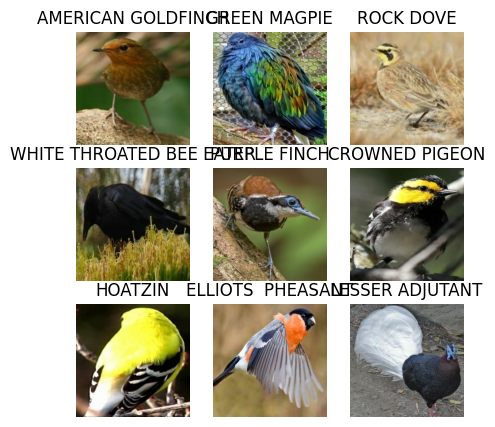

In [9]:
visualise_data = train_ds.take(1)
plt.figure(figsize=(5, 5))
for image, label in visualise_data:
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      img = image[i]/255.
      plt.imshow(img)
      plt.title(class_names[label[i].numpy().argmax()])
      plt.axis("off")

### Preprocessing Data Functions

In [10]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

@tf.function
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, (BATCH_SIZE,CROP_TO, CROP_TO, 3))
    image = image / 255.0
    return (image, label)


@tf.function
def preprocess_test(image, label):
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.0
    return (image, label)


DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 50 + 1  # To ensure at least there are 50 epochs of training

# Define the data pipeline

In [11]:
# Training pipeline
pipeline_train = (
    train_ds.shuffle(400)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    val_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

### Visualise Augumented Training Samples

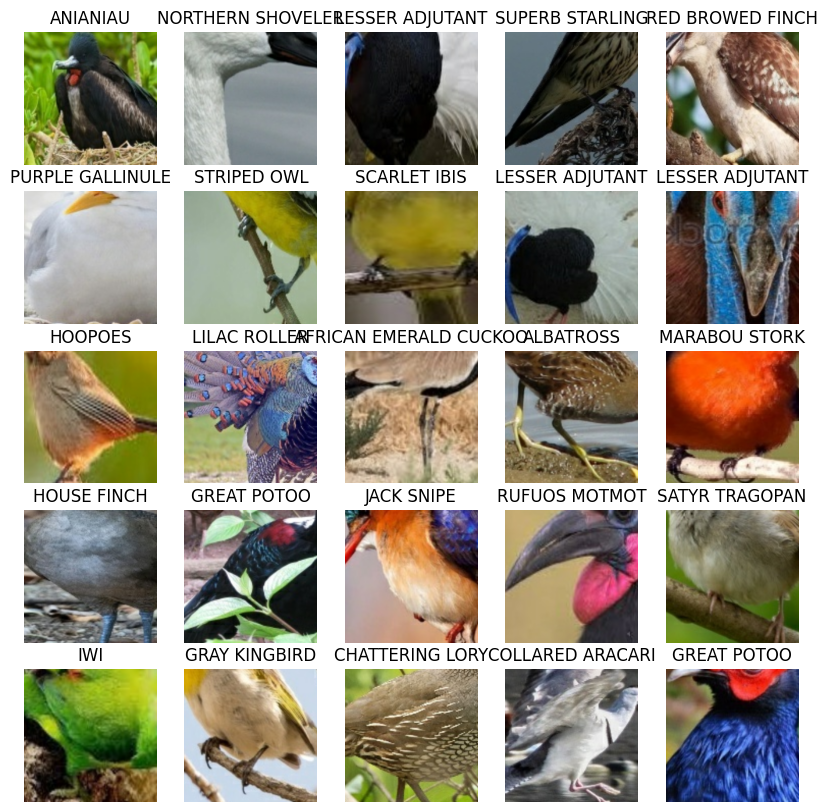

In [12]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    tit = class_names[int(np.array(label_batch[n]).argmax())]
    plt.title(tit)
    plt.axis("off")

### Load pretrained TF-Hub model into a KerasLayer

In [13]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

## Create BigTransfer model

In [14]:
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, activation = 'softmax', kernel_initializer="zeros")
        self.bit_model = module


    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)


model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

## Define optimizer and loss

In [15]:
#learning_rate = 0.003 * BATCH_SIZE / 512
learning_rate = 0.03 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.CategoricalCrossentropy()

### Compile Model

In [16]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

### CallBack

In [17]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        #monitor="val_loss", patience=2, restore_best_weights=True
        monitor="val_accuracy", patience=5, restore_best_weights=True
    )
]

### Train the model

In [18]:
history = model.fit(
    pipeline_train,
    epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks
)

Epoch 1/800


2022-10-30 17:41:11.319761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 6.2726 - accuracy: 0.0219

2022-10-30 17:41:26.836860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 59s 5s/step - loss: 6.2726 - accuracy: 0.0219 - val_loss: 6.2521 - val_accuracy: 0.0742
Epoch 2/800
10/10 [==============================] - 40s 4s/step - loss: 6.0723 - accuracy: 0.0688 - val_loss: 5.7371 - val_accuracy: 0.1458
Epoch 3/800
10/10 [==============================] - 39s 4s/step - loss: 5.6552 - accuracy: 0.1219 - val_loss: 5.2014 - val_accuracy: 0.1800
Epoch 4/800
10/10 [==============================] - 40s 4s/step - loss: 5.1898 - accuracy: 0.1313 - val_loss: 4.5877 - val_accuracy: 0.2298
Epoch 5/800
10/10 [==============================] - 40s 4s/step - loss: 4.7538 - accuracy: 0.2031 - val_loss: 4.0632 - val_accuracy: 0.2853
Epoch 6/800
10/10 [==============================] - 42s 5s/step - loss: 3.8907 - accuracy: 0.3063 - val_loss: 3.3684 - val_accuracy: 0.3840
Epoch 7/800
10/10 [==============================] - 41s 5s/step - loss: 3.6937 - accuracy: 0.2906 - val_loss: 3.0839 - val_accuracy: 0.4080
Epoch 8/800
10/10 [======

Runtime info: One epoch with the BigTransfer model takes roughly 41 seconds - total runtime: 32 minutes (~0.5hrs)

NOTE: val_accuracy varies a lot for very same run (between 0.73 - 0.88) 

---

Additional code up here

---

In [38]:
def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

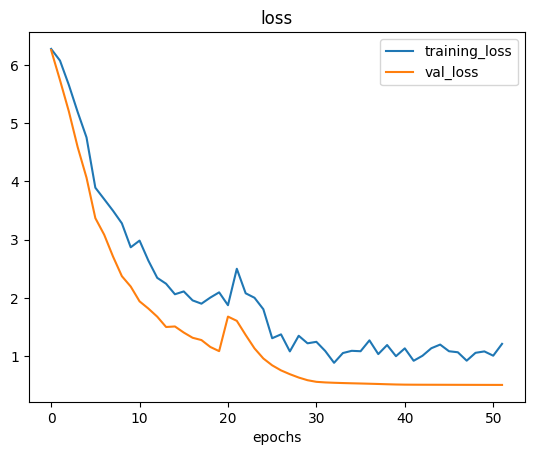

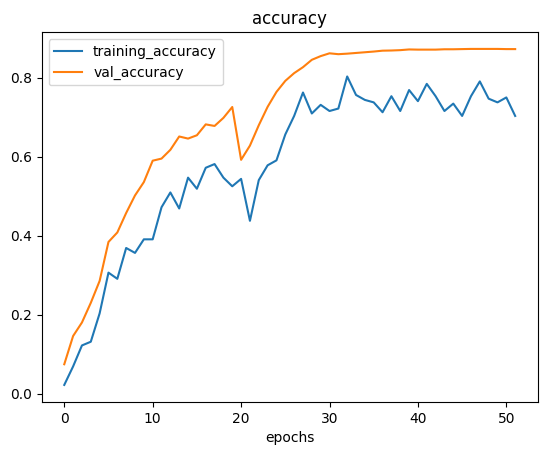

In [39]:
plot_loss_curves(history)

In [40]:
# Save the entire small model as a SavedModel.
#!mkdir -p saved_model
#model.save('saved_model/BigTransfer_Kaggle_p224_e45')

## 6. Making some predictions

In [41]:
img_height = 224

# cReating a function that preprocess the custom data
def load_and_prep_image(filename, img_shape = img_height):
  img = tf.io.read_file(filename) #read image
  img = tf.image.decode_image(img) # decode the image to a tensor
  img = tf.image.resize(img, size = [img_shape, img_shape]) # resize the image
  img = img/255. # rescale the image
  return img

In [42]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

Add new files to the test folder 

In [43]:
amsel = path + '/data/data_2/images to test/Amsel.jpeg'
blaumeise = path + '/data/data_2/images to test/blaumeise.jpeg'
buchfink = path + '/data/data_2/images to test/buchfink.jpeg'
elster = path + '/data/data_2/images to test/elster.jpeg'
feldsperling = path + '/data/data_2/images to test/feldsperling.jpeg'
firefinch = path + '/data/data_2/images to test/firefinch.jpg'
gruenfink = path + '/data/data_2/images to test/grünfink.jpeg'
haussperling = path + '/data/data_2/images to test/haussperling.jpeg'
kohlmeise = path + '/data/data_2/images to test/Kohlmeise.jpeg'
mauersegler = path + '/data/data_2/images to test/mauersegler.jpeg'
mehlschwalbe = path + '/data/data_2/images to test/mehlschwalbe.jpeg'
rotkehlchen = path + '/data/data_2/images to test/Rotkehlchen.jpeg'
star = path + '/data/data_2/images to test/Star.jpeg'

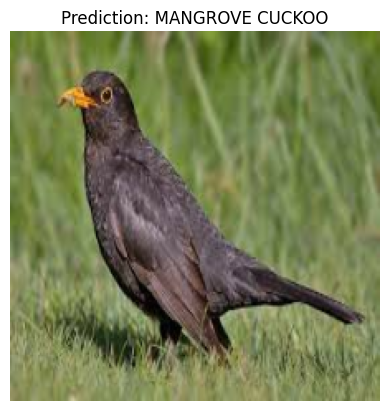

In [44]:
# amsel
pred_and_plot(model,amsel, class_names)

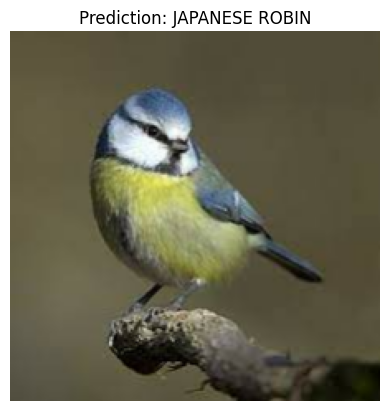

In [45]:
#blaumeise
pred_and_plot(model,blaumeise, class_names)

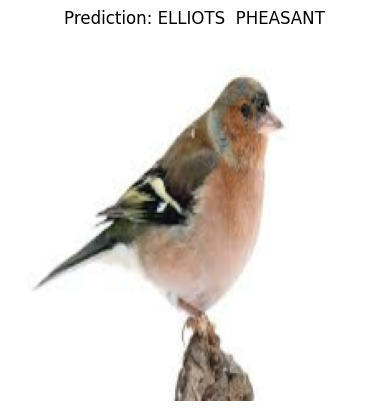

In [46]:
#buchfink
pred_and_plot(model,buchfink, class_names)

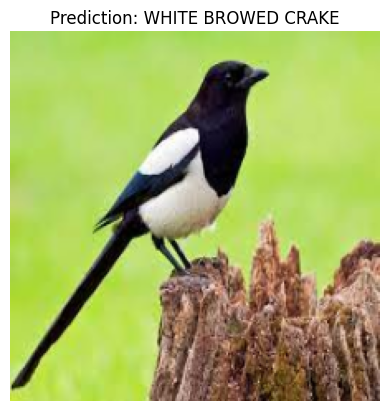

In [47]:
#elster
pred_and_plot(model,elster, class_names)

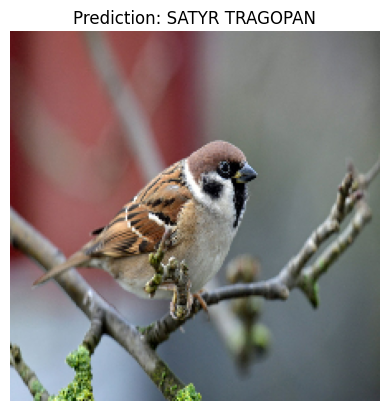

In [48]:
#feldsperling
pred_and_plot(model,feldsperling, class_names)

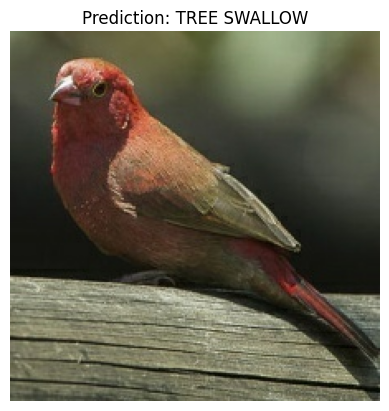

In [49]:
#firefinch
pred_and_plot(model,firefinch, class_names)

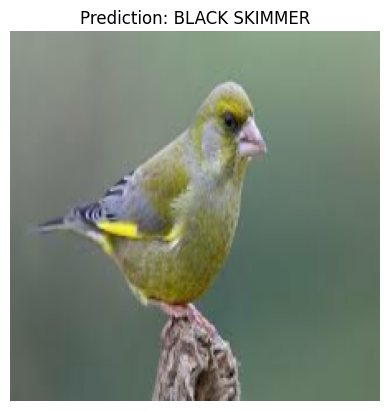

In [50]:
#gruenfink
pred_and_plot(model,gruenfink, class_names)

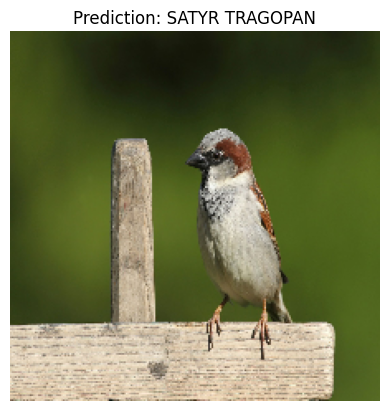

In [51]:
#haussperling
pred_and_plot(model,haussperling, class_names)

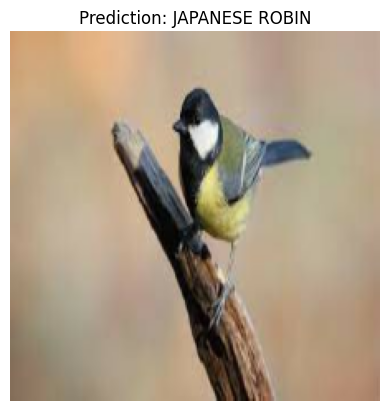

In [52]:
#kohlmeise
pred_and_plot(model,kohlmeise, class_names)

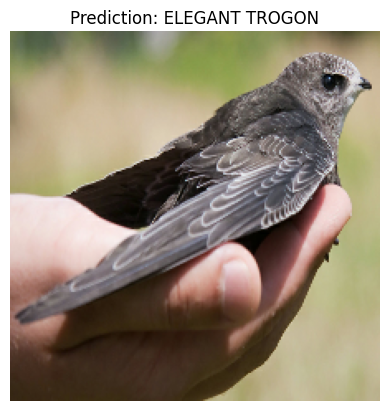

In [53]:
#mauersegler
pred_and_plot(model,mauersegler, class_names)

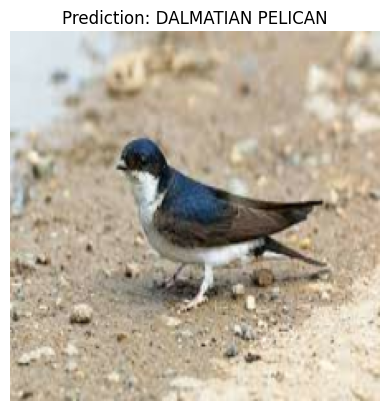

In [54]:
#mehlschwalbe
pred_and_plot(model,mehlschwalbe, class_names)

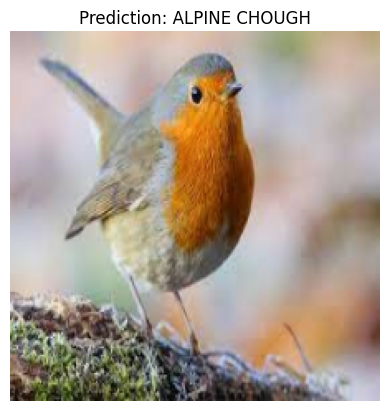

In [55]:
# rotkehlchen
pred_and_plot(model,rotkehlchen, class_names)

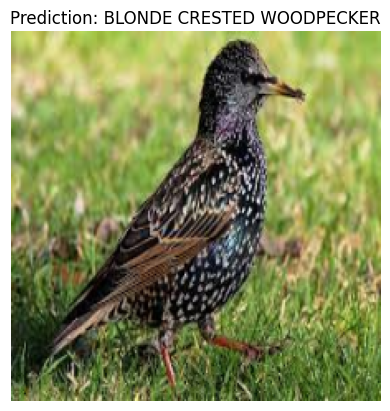

In [56]:
# star
pred_and_plot(model,star, class_names)